# Constructing Dataloaders

## Dataset download

Let's begin by downloading the data.

In [1]:
mkdir data

In [2]:
!cd data && wget https://archive.org/download/macaques/macaques.zip && unzip -q macaques.zip

--2021-01-25 10:23:21--  https://archive.org/download/macaques/macaques.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801505.us.archive.org/7/items/macaques/macaques.zip [following]
--2021-01-25 10:23:21--  https://ia801505.us.archive.org/7/items/macaques/macaques.zip
Resolving ia801505.us.archive.org (ia801505.us.archive.org)... 207.241.228.155
Connecting to ia801505.us.archive.org (ia801505.us.archive.org)|207.241.228.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132047998 (126M) [application/zip]
Saving to: ‘macaques.zip’

macaques.zip        100%[===================>] 125.93M  2.34MB/s    in 43s     

2021-01-25 10:24:05 (2.90 MB/s) - ‘macaques.zip’ saved [132047998/132047998]



And we now have everything that we need!

In [3]:
ls data

annotations.csv  macaques.zip  train/  valid/


The `annotations.csv` file contains label information. The data has been split into a train and validation set, but feel free to split it in any other way if that would be more appropriate. Retaining the split can help compare results. 

## Constructing the datasets

We will use vanilla `PyTorch`. We will convert audio to spectrograms and codenames to idices to be used as labels.

In [4]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing

import torch

For convenience, and to speed up training, let's load the data and zero pad the files to the duration of the longest recording.

In [9]:
anno = pd.read_csv('data/annotations.csv')
srs = []
for _, row in anno.iterrows():
    recording, sr = librosa.load(f'data/{row.split}/{row.filename}', sr=None)
    srs.append(sr)

In [2]:
anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, _ = librosa.load(f'data/{row.split}/{row.filename}')
    example = np.zeros((37308))
    example[:recording.shape[0]] = recording
    audio.append(example)
    
anno['audio'] = audio

We now have the audio stored in our pandas dataframe as a column.

In [3]:
anno.head()

,class,split,filename,audio
0,TH,train,TH28.wav,"[0.005602472461760044, 0.005318541079759598, 0..."
1,TH,train,TH22.wav,"[0.008311716839671135, 0.009628401137888432, 0..."
2,TH,train,TH928.wav,"[-0.005715873092412949, -0.006209362763911486,..."
3,TH,train,TH1145.wav,"[0.005164775066077709, 0.00611207215115428, 0...."
4,TH,valid,TH470.wav,"[-0.005707798525691032, -0.005975733976811171,..."


Let's save the modified annotation file that now includes audio so that we can easily access it from other notebooks.

In [4]:
anno.to_pickle('data/anno_with_audio.pkl')

We can listen to one of the examples to make sure everything worked.

In [5]:
Audio(anno.loc[0, 'audio'], rate=22050)

Here is what we need to do for each of the examples:
* convert the audio to a spectrogram
* assign label expressed as an integer

Here is how we can go from audio to a spectrogram using the [librosa library](https://librosa.org/doc/latest/index.html).

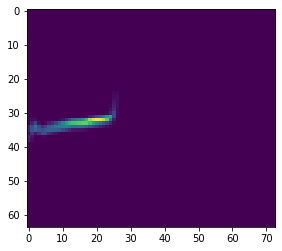

In [6]:
spec = librosa.feature.melspectrogram(
    anno.loc[0, 'audio'], fmin=200, fmax=800, n_mels=64
) # fmin and fmax taken from the paper
plt.imshow(spec);

Let us now develop a way of representing labels as integers.

In [7]:
codenames = anno['class'].unique().tolist()

codename2idx = {codename: idx for idx, codename in enumerate(codenames)}

Now that we have the components in place, let's work on our datasets.

In [8]:
t = anno[anno.split == 'train']

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.examples = df
        
    def __getitem__(self, index):
        example = self.examples.iloc[index]
        x = librosa.feature.melspectrogram(
            example.audio, fmin=200, fmax=800, n_mels=64
        )
        y = codename2idx[example['class']]
        return x, y

    def __len__(self):
        return self.examples.shape[0]

In [10]:
train_ds = Dataset(anno[anno.split == 'train'])
valid_ds = Dataset(anno[anno.split == 'valid'])

Let's now construct the dataloaders to ensure everything works as expected.

In [11]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count()-1
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count()-1
)

In [12]:
for batch in train_dl: pass
for batch in valid_dl: pass

In [13]:
batch[0].shape, batch[1].shape # we are on the final batch, there were not enough examples to fill it

(torch.Size([17, 64, 73]), torch.Size([17]))